# Дипломная работа по курсу «Python для анализа данных»  

Дан файл HR.csv с данными по опросу уровня удовлетворенности сотрудниками работой.  
Файл доступен тут -
https://drive.google.com/file/d/1INgo03nal-vwFJe7Lec5vOUtOwfJdUr1/view?usp=sharing

Признаки:
1. **satisfaction_level** - Уровень удовлетворенности работой
2. **last_evaluation** - Время с момента последней оценки в годах
3. **number_project** - Количество проектов, выполненных за время работы
4. **average_montly_hours** - Среднее количество часов на рабочем месте в месяц
5. **time_spend_company** - Стаж работы в компании в годах
6. **Work_accident** - Происходили ли несчастные случаи на рабочем месте с сотрудником
7. **left** - Уволился ли сотрудник
8. **promotion_last_5years** - Повышался ли сотрудник за последние пять лет
9. **department** - Отдел, в котором работает сотрудник
10. **salary** - Относительный уровень зарплаты

Требуется выполнить следующие задания:
1. Загрузите файл HR.csv в pandas dataframe.
2. Рассчитайте основные статистики для переменных (среднее, медиана, мода, мин/макс, сред. отклонение).
3. Рассчитайте и визуализировать корреляционную матрицу для количественных переменных. Определите две самые скоррелированные и две наименее скоррелированные переменные.
4. Рассчитайте сколько сотрудников работает в каждом департаменте.
5. Покажите распределение сотрудников по зарплатам.
6. Покажите распределение сотрудников по зарплатам в каждом департаменте по отдельности.
7. Проверьте гипотезу, что сотрудники с высоким окладом проводят на работе больше времени, чем сотрудники с низким окладом.
8. Рассчитайте следующие показатели среди уволившихся и не уволившихся сотрудников (по отдельности):  
● Доля сотрудников с повышением за последние 5 лет;  
● Средняя степень удовлетворенности;  
● Среднее количество проектов.  
9. Разделите данные на тестовую и обучающую выборки. Постройте модель LDA, предсказывающую уволился ли сотрудник на основе имеющихся факторов (кроме department и salary). Оцените качество модели на тестовой выборке.
10. Загрузите jupyter notebook решение на github и пришлите ссылку.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.figsize'] = 10, 7

1. Загрузите файл HR.csv в pandas dataframe.

In [2]:
print("Исходные данные (первые 10 строк)")
hr = pd.read_csv("HR.csv")
display(HTML(hr.head(10).to_html()))
hr.info()
print("\nВывод: в данных нет пропусков.")

Исходные данные (первые 10 строк)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB

Вывод: в данных нет пропусков.


2. Рассчитайте основные статистики для переменных (среднее, медиана, мода, мин/макс, сред. отклонение).

In [3]:
def get_metrics(df, field, is_numeric):
    if is_numeric:
        return [df[field].min(), df[field].max(), df[field].mean(), df[field].mode()[0], df[field].median(), df[field].std()]
    else:
        return [np.NaN, np.NaN, np.NaN, df[field].mode()[0], np.NaN, np.NaN]

print("Столбцы 'department' и 'salary' категориальные, поэтому для них имеет смысл рассчитывать только моду.")

columns = hr.columns
types = (True, True, True, True, True, True, True, True, False, False)
info = zip(columns, types)
main = []
for inf in info:
    main.append([inf[0]] + get_metrics(hr, inf[0], inf[1]))
values = pd.DataFrame(main, columns=["Параметр", "Минимум", "Максимум", "Среднее", "Мода", "Медиана", "СКО"]).set_index("Параметр")
display(HTML(values.to_html()))

Столбцы 'department' и 'salary' категориальные, поэтому для них имеет смысл рассчитывать только моду.


,Минимум,Максимум,Среднее,Мода,Медиана,СКО
Параметр,,,,,,
satisfaction_level,0.09,1.0,0.612834,0.1,0.64,0.248631
last_evaluation,0.36,1.0,0.716102,0.55,0.72,0.171169
number_project,2.00,7.0,3.803054,4,4.00,1.232592
average_montly_hours,96.00,310.0,201.050337,135,200.00,49.943099
time_spend_company,2.00,10.0,3.498233,3,3.00,1.460136
Work_accident,0.00,1.0,0.144610,0,0.00,0.351719
left,0.00,1.0,0.238083,0,0.00,0.425924
promotion_last_5years,0.00,1.0,0.021268,0,0.00,0.144281
department,NaN,NaN,NaN,sales,NaN,NaN


3. Рассчитайте и визуализировать корреляционную матрицу для количественных переменных. Определите две самые скоррелированные и две наименее скоррелированные переменные.

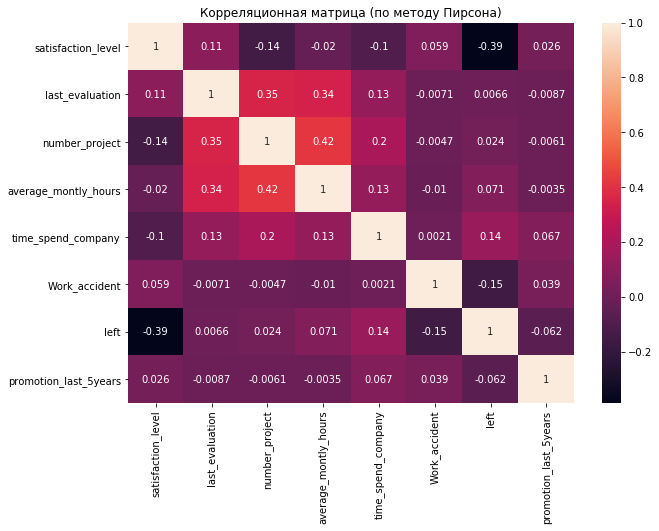

Наименьшая корреляция между 'time_spend_company' и 'Work_accident' равна 0.00212041809671425.
Наибольшая корреляция между 'number_project' и 'average_montly_hours' равна 0.4172106344017606.


In [4]:
def get_min_max_corr(corr):
    mtx = corr.to_numpy()
    min_v = None
    max_v = None
    min_p = None, None
    max_p = None, None
    for i in range(len(mtx)):
        for j in range(i + 1, len(mtx[i])):
            if min_v is None or min_v > abs(mtx[i][j]):
                min_v = abs(mtx[i][j])
                min_p = i, j
            if max_v is None or max_v < abs(mtx[i][j]):
                max_v = abs(mtx[i][j])
                max_p = i, j
    return min_p, max_p


corr = hr.iloc[:, 0:8].corr(method="pearson")
sns.heatmap(corr, annot=True)
plt.title("Корреляционная матрица (по методу Пирсона)")
plt.show()

min_p, max_p = get_min_max_corr(corr)
print(f"Наименьшая корреляция между '{corr.index[min_p[0]]}' и '{corr.columns[min_p[1]]}' равна {corr.iloc[min_p]}.")
print(f"Наибольшая корреляция между '{corr.index[max_p[0]]}' и '{corr.columns[max_p[1]]}' равна {corr.iloc[max_p]}.")

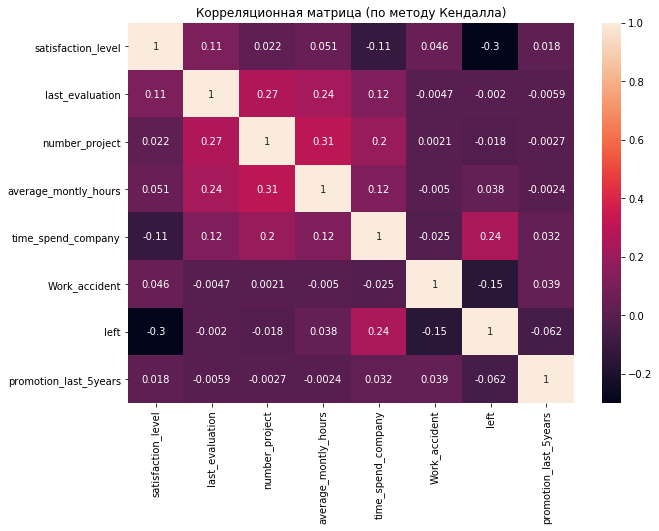

Наименьшая корреляция между 'last_evaluation' и 'left' равна -0.00201000692891097.
Наибольшая корреляция между 'number_project' и 'average_montly_hours' равна 0.3069867487951578.


In [5]:
corr = hr.iloc[:, 0:8].corr(method="kendall")
sns.heatmap(corr, annot=True)
plt.title("Корреляционная матрица (по методу Кендалла)")
plt.show()

min_p, max_p = get_min_max_corr(corr)
print(f"Наименьшая корреляция между '{corr.index[min_p[0]]}' и '{corr.columns[min_p[1]]}' равна {corr.iloc[min_p]}.")
print(f"Наибольшая корреляция между '{corr.index[max_p[0]]}' и '{corr.columns[max_p[1]]}' равна {corr.iloc[max_p]}.")

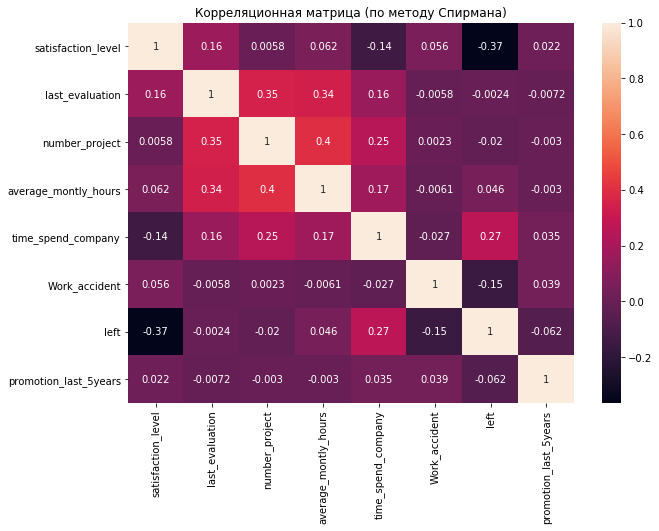

Наименьшая корреляция между 'number_project' и 'Work_accident' равна 0.0023276242127821386.
Наибольшая корреляция между 'number_project' и 'average_montly_hours' равна 0.3978551973725825.

Вывод: как видим, матрицы корреляции по всем трём методам получились примерно одинаковые.
По всем методам расчета наибольшая корреляция прослеживается между 'number_project' и 'average_montly_hours'.
Наименьшая - в каждом методе своя, но видно, что значения по абсолютной величине различаются не сильно.


In [6]:
corr = hr.iloc[:, 0:8].corr(method="spearman")
sns.heatmap(corr, annot=True)
plt.title("Корреляционная матрица (по методу Спирмана)")
plt.show()

min_p, max_p = get_min_max_corr(corr)
print(f"Наименьшая корреляция между '{corr.index[min_p[0]]}' и '{corr.columns[min_p[1]]}' равна {corr.iloc[min_p]}.")
print(f"Наибольшая корреляция между '{corr.index[max_p[0]]}' и '{corr.columns[max_p[1]]}' равна {corr.iloc[max_p]}.")

print("\nВывод: как видим, матрицы корреляции по всем трём методам получились примерно одинаковые.")
print("По всем методам расчета наибольшая корреляция прослеживается между 'number_project' и 'average_montly_hours'.")
print("Наименьшая - в каждом методе своя, но видно, что значения по абсолютной величине различаются не сильно.")

4. Рассчитайте сколько сотрудников работает в каждом департаменте.

In [7]:
print("Кол-во работников по каждому департаменту")
counts = hr.groupby("department").count()[["satisfaction_level"]].sort_values("satisfaction_level", ascending=False)
counts.columns=["count"]
display(HTML(counts.to_html()))
print("Вывод: больше всего сотрудников работает в отделе продаж, меньше всего - в управлении.")

Кол-во работников по каждому департаменту


,count
department,
sales,4140
technical,2720
support,2229
IT,1227
product_mng,902
marketing,858
RandD,787
accounting,767
hr,739


Вывод: больше всего сотрудников работает в отделе продаж, меньше всего - в управлении.


5. Покажите распределение сотрудников по зарплатам.

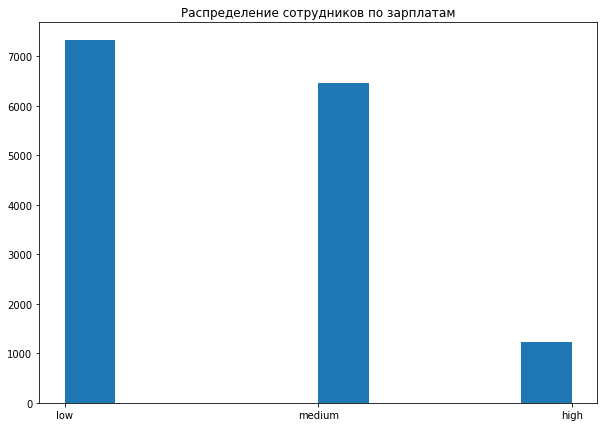

Вывод: Больше всего сотрудников с маленькой зарплатой, со средней - немного меньше, и менее всего - с высокой зарплатой.


In [8]:
plt.hist(hr["salary"])
plt.title("Распределение сотрудников по зарплатам")
plt.show()
print("Вывод: Больше всего сотрудников с маленькой зарплатой, со средней - немного меньше, и менее всего - с высокой зарплатой.")

6. Покажите распределение сотрудников по зарплатам в каждом департаменте по отдельности.

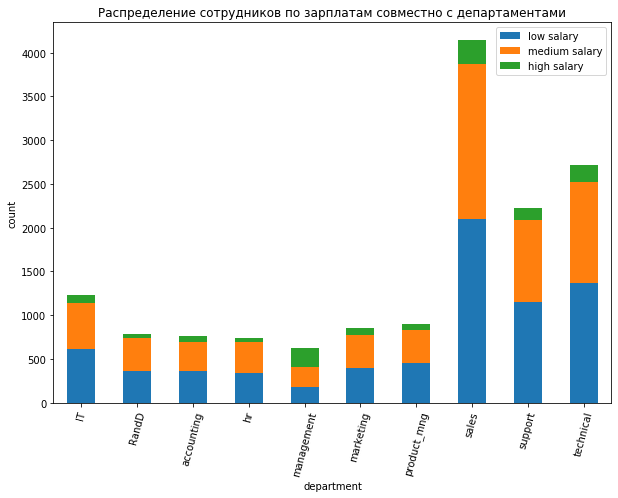

Вывод: нет одинакого соотношения в распределении зарплат сотрудников между департаментами.


In [9]:
salaries = hr.groupby(["department", "salary"]).count()[["satisfaction_level"]]
salaries.columns = ["count"]
salaries = salaries.unstack().iloc[:, [1, 2, 0]]

fig, ax = plt.subplots()
salaries.plot(kind='bar', rot=75, stacked=True, ax=ax, title="Распределение сотрудников по зарплатам совместно с департаментами")
ax.set_ylabel("count")
ax.legend(["low salary", "medium salary", "high salary"])
plt.show()

print("Вывод: нет одинакого соотношения в распределении зарплат сотрудников между департаментами.")

7. Проверьте гипотезу, что сотрудники с высоким окладом проводят на работе больше времени, чем сотрудники с низким окладом.

In [10]:
print("Нулевая гипотеза: сотрудники с высоким и низким окладом проводят на работе одинаковое кол-во времени.")
print("Выборки независимы, поэтому воспользуемся критерием Стьюдента.")

alpha = 0.05
print(f"Используем традиционный уровень значимости α = {alpha}.")
high = hr[hr["salary"] == "high"]["average_montly_hours"]
low = hr[hr["salary"] == "low"]["average_montly_hours"]
result = sp.ttest_ind(high, low, equal_var=False)
print(f"Значение p-value = {result.pvalue}.")
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу.")
    if result.statistic > 0:
        print("\nВывод: сотрудники с высоким окладом, действительно, проводят на работе больше времени, чем сотрудники с низким окладом.")
    else:
        print("\nВывод: сотрудники с высоким окладом, наоборот, проводят на работе меньше времени, чем сотрудники с низким окладом.")
else:
    print("Не отвергаем нулевую гипотезу.")
    print("\nВывод: сотрудники с высоким окладом проводят на работе столько же времени, сколько и сотрудники с низким окладом.")

Нулевая гипотеза: сотрудники с высоким и низким окладом проводят на работе одинаковое кол-во времени.
Выборки независимы, поэтому воспользуемся критерием Стьюдента.
Используем традиционный уровень значимости α = 0.05.
Значение p-value = 0.4459045542257889.
Не отвергаем нулевую гипотезу.

Вывод: сотрудники с высоким окладом проводят на работе столько же времени, сколько и сотрудники с низким окладом.


8. Рассчитайте следующие показатели среди уволившихся и не уволившихся сотрудников (по отдельности):  
● Доля сотрудников с повышением за последние 5 лет;  
● Средняя степень удовлетворенности;  
● Среднее количество проектов.  

In [11]:
left = hr[hr["left"] == 1][["satisfaction_level", "number_project", "promotion_last_5years"]]
work = hr[hr["left"] == 0][["satisfaction_level", "number_project", "promotion_last_5years"]]

promotion_l = len(left[left["promotion_last_5years"] != 0]) * 100 / len(left)
promotion_w = len(work[work["promotion_last_5years"] != 0]) * 100 / len(work)
satisfaction_l = left["satisfaction_level"].mean()
satisfaction_w = work["satisfaction_level"].mean()
projects_l = left["number_project"].mean()
projects_w = work["number_project"].mean()

eps = 2
table = pd.DataFrame([
                [round(promotion_l, eps), round(promotion_w, eps)],
                [round(satisfaction_l, eps), round(satisfaction_w, eps)],
                [round(projects_l, eps), round(projects_w, eps)]
            ],
            columns=["left", "work"],
            index=["promotion part, %", "satisfaction mean", "project count mean"]
        )

display(HTML(table.to_html()))
print("Глядя на таблицу можно заметить отличия в результатах для уволившихся и работающих сотрудников.")
print("Чтобы их корректно проинтерпретировать убедимся сперва, что эти отличия значимы.")
print("Воспользуемся критерием Стьюдента и рассчитаем значение p-value.")

alpha = 0.05
print(f"Используем традиционный уровень значимости α = {alpha}.")
promotion_t = sp.ttest_ind(left["promotion_last_5years"], work["promotion_last_5years"], equal_var=False)
satisfaction_t = sp.ttest_ind(left["satisfaction_level"], work["satisfaction_level"], equal_var=False)
projects_t = sp.ttest_ind(left["number_project"], work["number_project"], equal_var=False)

table["p-value"] = [round(promotion_t.pvalue, 5), round(satisfaction_t.pvalue, 5), round(projects_t.pvalue, 5)]
table["p-value < α"] = [promotion_t.pvalue < alpha, satisfaction_t.pvalue < alpha, projects_t.pvalue < alpha]
display(HTML(table.to_html()))

print("Вывод: как видим, все отличия значимы. Уволившиеся сотрудники реже получали повышение, у них был ниже уровень удовлетворенностью работой и работали они над большим числом проектов.")
print("Можно предположить, что все это могло стать поводом для увольнения.")

,left,work
"promotion part, %",0.53,2.63
satisfaction mean,0.44,0.67
project count mean,3.86,3.79


Глядя на таблицу можно заметить отличия в результатах для уволившихся и работающих сотрудников.
Чтобы их корректно проинтерпретировать убедимся сперва, что эти отличия значимы.
Воспользуемся критерием Стьюдента и рассчитаем значение p-value.
Используем традиционный уровень значимости α = 0.05.


,left,work,p-value,p-value < α
"promotion part, %",0.53,2.63,0.00000,True
satisfaction mean,0.44,0.67,0.00000,True
project count mean,3.86,3.79,0.03034,True


Вывод: как видим, все отличия значимы. Уволившиеся сотрудники реже получали повышение, у них был ниже уровень удовлетворенностью работой и работали они над большим числом проектов.
Можно предположить, что все это могло стать поводом для увольнения.


9. Разделите данные на тестовую и обучающую выборки. Постройте модель LDA, предсказывающую уволился ли сотрудник на основе имеющихся факторов (кроме department и salary). Оцените качество модели на тестовой выборке.

In [12]:
def get_significant_param(vals, strings):
    vals_abs = [abs(x) for x in vals]
    max_ = max(vals_abs)
    idx = vals_abs.index(max_)
    if vals[idx] < 0:
        dep = "обратная зависимость"
    else:
        dep = "прямая зависимость"
    return strings[idx], dep

def tune_lda_params(data_train, y_train, data_test, y_test, shrinkage_num, tests):
    max_v = None
    max_p = None, None
    cmtx = None
    coef = None
    shrinkages_svd = [None]
    shrinkages_other = np.linspace(0, 1, shrinkage_num + 1)
    for solver in ["svd", "lsqr", "eigen"]:
        if solver == "svd":
            shrinkages = shrinkages_svd
        else:
            shrinkages = shrinkages_other
        for shrinkage in shrinkages:
            lst = []
            for i in range(tests):
                lda = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage)
                lda.fit(data_train, y_train)
                predict = lda.predict(data_test)
                lst.append(accuracy_score(y_test, lda.predict(data_test)))
            mean = np.mean(lst)
            if max_v is None or max_v < mean:
                max_v = mean
                max_p = solver, shrinkage
                cmtx = confusion_matrix(y_test, predict)
                coef = lda.coef_
    return max_v, max_p, cmtx, coef


# разделяем данные
test_size = 0.2
print(f"Разделим данные на обучающую и тестовую выборки в соотношении {round((1 - test_size) * 100)}% / {round(test_size * 100)}%.")
source = hr.iloc[:, 0:8]
data_train, data_test = train_test_split(source, test_size=test_size)
y_train, y_test = data_train["left"], data_test["left"]
del data_train["left"]
del data_test["left"]

# обучаем модель и делаем предсказание
lda = LinearDiscriminantAnalysis()
lda.fit(data_train, y_train)
prediction = lda.predict(data_test)

# строим матрицу ошибок
columns = [["prediction", "prediction"], ["0", "1"]]
index = [["test", "test"], ["0", "1"]]
cmtx = pd.DataFrame(confusion_matrix(y_test, prediction), columns=columns, index=index)
print("\nМатрица ошибок для модели с параметрами по умолчанию")
display(HTML(cmtx.to_html()))

# вычисляем качество модели
accur = accuracy_score(y_test, prediction)
print(f"Построенная модель в {round(accur * 100, 2)}% случаев работает верно.")

# выделяем наиболее значимый параметр влияния
s_param, s_dep = get_significant_param(lda.coef_[0], source.columns)
print(f"\nНаиболее значимый параметр: '{s_param}' ({s_dep}).")

print("\nПопробуем подобрать параметры модели LDA для более точного предсказания.")
max_v, max_p, cmtx, coef = tune_lda_params(data_train, y_train, data_test, y_test, 10, 10)

print("\nМатрица ошибок для модели с подобранными параметрами")
cmtx = pd.DataFrame(cmtx, columns=columns, index=index)
display(HTML(cmtx.to_html()))

print(f"Построенная модель в {round(max_v * 100, 2)}% случаев работает верно (при solver = '{max_p[0]}', shrinkage = {max_p[1]}).")

# выделяем наиболее значимый параметр влияния
s_param, s_dep = get_significant_param(coef[0], source.columns)
print(f"\nНаиболее значимый параметр: '{s_param}' ({s_dep}).")

print("\nВывод: по численной оценке модель с подобранными параметрами (МПП) не намного лучше выполняет предсказание, чем модель с параметрами по умолчанию (МПУ).")
print("Соотношение между ошибками I и II рода в моделях существенно изменилось.")
print("По-видимому, это сказалось на определении наиболее значимого параметра, влияющего на уход сотрудника.")
print("Так, в МПУ этот параметр определен как 'satisfaction_level', а в МПП - 'average_montly_hours'.")
print("Если принять во внимание, что 'average_montly_hours' сильно коррелируется с 'number_project' по всем 3-м методам расчета корреляции, то это еще раз подтвердит вывод о влиянии параметров 'satisfaction_level' и 'number_project' на увольнение сотрудников, сделанный в задании 8.")

Разделим данные на обучающую и тестовую выборки в соотношении 80% / 20%.

Матрица ошибок для модели с параметрами по умолчанию


Построенная модель в 76.3% случаев работает верно.

Наиболее значимый параметр: 'satisfaction_level' (обратная зависимость).

Попробуем подобрать параметры модели LDA для более точного предсказания.

Матрица ошибок для модели с подобранными параметрами


Построенная модель в 78.07% случаев работает верно (при solver = 'lsqr', shrinkage = 0.9).

Наиболее значимый параметр: 'average_montly_hours' (прямая зависимость).

Вывод: по численной оценке модель с подобранными параметрами (МПП) не намного лучше выполняет предсказание, чем модель с параметрами по умолчанию (МПУ).
Соотношение между ошибками I и II рода в моделях существенно изменилось.
По-видимому, это сказалось на определении наиболее значимого параметра, влияющего на уход сотрудника.
Так, в МПУ этот параметр определен как 'satisfaction_level', а в МПП - 'average_montly_hours'.
Если принять во внимание, что 'average_montly_hours' сильно коррелируется с 'number_project' по всем 3-м методам расчета корреляции, то это еще раз подтвердит вывод о влиянии параметров 'satisfaction_level' и 'number_project' на увольнение сотрудников, сделанный в задании 8.


10. Загрузите jupyter notebook решение на github и пришлите ссылку.

Сделано.